In [1]:
%load_ext autoreload
%autoreload 2

# Classification Task

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
#from scipy.fft import fft2, ifft2, fft, ifft

#from torchvision import datasets
import torchvision.transforms as transforms
import torch
#import torch.nn as nn
#import torch.nn.functional as F
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)
#sys.path.insert(0, '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/lib/')
import MURA as mura
from CNN import CNN

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times" #"Computer Modern Serif"
})

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
wandb.init(project="coded-aperture-MNIST", group="2_convolutions")

wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


In [6]:
# capture a dictionary of hyperparameters with config
params = {
 # "dataset": "MNIST",
 # "machine": "desktop",
 # "model": "CNN -- 2 conv",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 50,
}
wandb.config = params

# Load MNIST Data

In [8]:
# Compute MURA encoder and decoder
p = 23 # size of array
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

# define CNN and get data
model = CNN()
train_data, test_data = model._get_dataset(A)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) 
PATH = f'../models/mnist_{params["epochs"]}epochs.pth'
#wandb.watch(net)

In [9]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=False, 
                                          num_workers=0),
}

## Train

In [10]:
for epoch in range(params['epochs']):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loaders['train']):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
        wandb.log({"epoch": epoch, "loss": running_loss})
print('Finished Training')
# Save model

torch.save(model.state_dict(), PATH)
wandb.finish()

[1,   100] loss: 0.112
[1,   200] loss: 0.080
[1,   300] loss: 0.052
[1,   400] loss: 0.040
[1,   500] loss: 0.032
[1,   600] loss: 0.030
[2,   100] loss: 0.026
[2,   200] loss: 0.024
[2,   300] loss: 0.021
[2,   400] loss: 0.021
[2,   500] loss: 0.018
[2,   600] loss: 0.016
[3,   100] loss: 0.017
[3,   200] loss: 0.015
[3,   300] loss: 0.015
[3,   400] loss: 0.014
[3,   500] loss: 0.015
[3,   600] loss: 0.014
[4,   100] loss: 0.012
[4,   200] loss: 0.012
[4,   300] loss: 0.012
[4,   400] loss: 0.012
[4,   500] loss: 0.012
[4,   600] loss: 0.012
[5,   100] loss: 0.011
[5,   200] loss: 0.011
[5,   300] loss: 0.010
[5,   400] loss: 0.011
[5,   500] loss: 0.011
[5,   600] loss: 0.012
[6,   100] loss: 0.011
[6,   200] loss: 0.010
[6,   300] loss: 0.010
[6,   400] loss: 0.009
[6,   500] loss: 0.010
[6,   600] loss: 0.009
[7,   100] loss: 0.009
[7,   200] loss: 0.010
[7,   300] loss: 0.009
[7,   400] loss: 0.010
[7,   500] loss: 0.009
[7,   600] loss: 0.009
[8,   100] loss: 0.009
[8,   200] 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▂▁▃▂▁▂▂▁▂▂▁▂▂▁▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁
epoch,49
loss,0.0


## Evaluate

In [11]:
# Load model if one is not loaded already
#PATH = '../models/mnist_net.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
dataiter = iter(loaders['test'])
images, labels = dataiter.next()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
    
        # calculate outputs by running images through the network (done in batches)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 95 %


In [14]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label.numpy())] += 1
            total_pred[int(label.numpy())] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5d} is {accuracy:.1f} %')

Accuracy for class:     0 is 97.9 %
Accuracy for class:     1 is 98.8 %
Accuracy for class:     2 is 95.9 %
Accuracy for class:     3 is 93.6 %
Accuracy for class:     4 is 95.8 %
Accuracy for class:     5 is 92.2 %
Accuracy for class:     6 is 97.4 %
Accuracy for class:     7 is 93.5 %
Accuracy for class:     8 is 93.4 %
Accuracy for class:     9 is 94.4 %


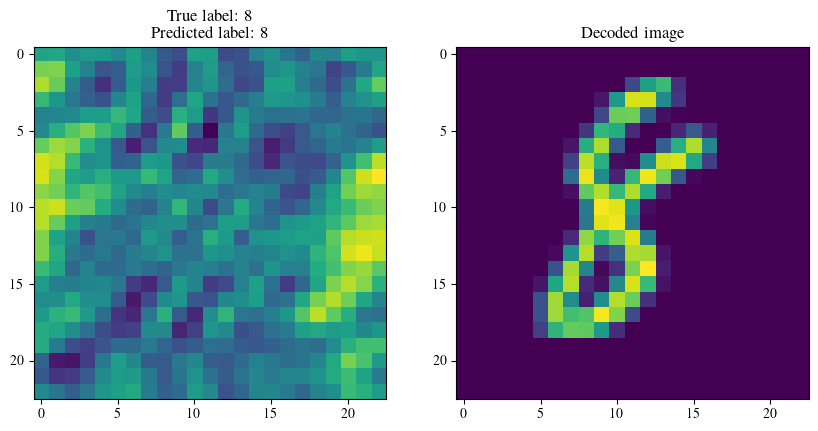

In [15]:
index = 0
img = images[index][0]
true_img = mura.FFT_convolve(img.numpy(), G)
pred_lab = predicted[index]
true_lab = labels[index]

fig, axs = plt.subplots(1,2, figsize=(10,7))
axs = axs.ravel()
axs[0].imshow(img)
axs[1].imshow(true_img)
axs[0].set_title(f"True label: {true_lab} \n Predicted label: {pred_lab}")
axs[1].set_title("Decoded image")
plt.show()

# To be deleted